# Flow-Shop Problem-Solving with Google `FunSearch`

> Authors: CUI Guangyuan, LI Songyan, XU Zhuojun

This notebook is the main entrance of our work on the flow-shop problems' solving using Google `FunSearch` via various attempts. Mainly, the applications of existing methods on the problem-solving can be divided into three categories: baseline experiments including the applications of Google `FunSearch` and `OR-Tools` as well as the existing heuristics (only NEH algorithm). New approaches are also proposed in this research, including:

- Trials on different kinds of prompts (Prompt Engineering)
- FunSearch with Curriculum Learning

> Environment setup before the execution (**IMPORTANT**):
> - Our experiments are operated under the anaconda virtual environment
>
> You can follow the instructions below to setup the correct environment:
> - `conda create -n funsearch_env -f environment.yml`

## Dataset for Evaluation and Testing

In [1]:
instance1 = "data/carlier/carlier1.txt"
instance2 = "data/carlier/carlier2.txt"
instance3 = "data/heller/heller1.txt"
instance4 = "data/heller/heller2.txt"
instance5 = "data/reeves/reeves1.txt"
instance6 = "data/reeves/reeves2.txt"
instance7 = "data/reeves/reeves3.txt"

instances = [
    instance1,
    instance2,
    # instance3,
    instance4,
    instance5,
    instance6,
    instance7
]

## Baseline Experiments

### Existing Heuristics

In [2]:
import time
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

Parse the input data:

In [3]:
def parse_input(input_data):
    lines = input_data.strip().split('\n')
    n_jobs, n_machines = map(int, lines[0].split())
    
    jobs = []
    for i in range(1, n_jobs + 1):
        job_data = lines[i].split()
        job = []
        for j in range(0, 2 * n_machines, 2):
            machine = int(job_data[j])
            processing_time = int(job_data[j + 1])
            job.append((machine, processing_time))
        jobs.append(job)
    
    return n_jobs, n_machines, jobs

Calculate makespan for a given job sequence:

In [4]:
def calculate_makespan(jobs, job_sequence, n_machines):
    machine_times = [0] * n_machines
    
    for job_idx in job_sequence:
        job = jobs[job_idx]
        for (machine, processing_time) in job:
            if machine == 0:
                machine_times[machine] = machine_times[machine] + processing_time
            else:
                machine_times[machine] = max(machine_times[machine], machine_times[machine - 1]) + processing_time
    
    return machine_times[-1]

Function to visualize the schedule:

In [5]:
def visualize_schedule(jobs, job_sequence, n_machines, algorithm_name):
    # Calculate start and end times for each operation
    machine_times = [0] * n_machines
    schedule = []
    
    for job_idx in job_sequence:
        job = jobs[job_idx]
        job_schedule = []
        
        for machine, processing_time in job:
            if machine == 0:
                start_time = machine_times[machine]
            else:
                start_time = max(machine_times[machine], machine_times[machine - 1])
            
            end_time = start_time + processing_time
            machine_times[machine] = end_time
            job_schedule.append((machine, start_time, end_time))
        
        schedule.append(job_schedule)
    
    # Create the visualization
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Define colors for jobs
    colors = plt.cm.tab10.colors
    
    # Plot each operation
    for i, job_schedule in enumerate(schedule):
        job_idx = job_sequence[i]
        for machine, start, end in job_schedule:
            ax.barh(machine, end - start, left=start, height=0.8, 
                   color=colors[job_idx % len(colors)], alpha=0.8,
                   edgecolor='black', linewidth=1)
            
            # Add job number label
            if end - start > 30:  # Only add text if bar is wide enough
                ax.text(start + (end - start) / 2, machine, f'J{job_idx}', 
                       ha='center', va='center', color='black', fontweight='bold')
    
    # Add legend
    legend_elements = [Patch(facecolor=colors[i % len(colors)], edgecolor='black', label=f'Job {i}')
                      for i in range(len(jobs))]
    ax.legend(handles=legend_elements, loc='upper right')
    
    # Set labels and title
    ax.set_xlabel('Time')
    ax.set_ylabel('Machine')
    ax.set_yticks(range(n_machines))
    ax.set_yticklabels([f'Machine {i}' for i in range(n_machines)])
    ax.set_title(f'Flow Shop Schedule - {algorithm_name}\nMakespan: {machine_times[-1]}')
    
    # Add grid
    ax.grid(True, axis='x', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    return fig

Definition of NEH algorithm:

In [6]:
def neh_algorithm(jobs, n_jobs, n_machines):
    # Calculate total processing time for each job
    job_times = []
    for i, job in enumerate(jobs):
        total_time = sum(time for _, time in job)
        job_times.append((i, total_time))
    
    # Sort jobs by total processing time (descending)
    job_times.sort(key=lambda x: x[1], reverse=True)
    
    # Build sequence incrementally
    sequence = [job_times[0][0]]
    
    for i in range(1, n_jobs):
        job_idx = job_times[i][0]
        best_makespan = float('inf')
        best_position = 0
        
        # Try inserting the job at each possible position
        for j in range(len(sequence) + 1):
            test_sequence = sequence.copy()
            test_sequence.insert(j, job_idx)
            makespan = calculate_makespan(jobs, test_sequence, n_machines)
            
            if makespan < best_makespan:
                best_makespan = makespan
                best_position = j
        
        sequence.insert(best_position, job_idx)
    
    makespan = calculate_makespan(jobs, sequence, n_machines)
    return sequence, makespan

Run and evaluate original NEH algorithm as the baseline:

In [7]:
def run_base_neh(instances, verbose=False):

    res = []

    for ins in instances:
        with open(ins, 'r') as f:
            input_data = f.read()

        n_jobs, n_machines, jobs = parse_input(input_data)

        if verbose:
            print(f"Problem: {ins} | Jobs: {n_jobs} | Machines: {n_machines}")
            
        start_time = time.time()
        sequence, makespan = neh_algorithm(jobs, n_jobs, n_machines)
        end_time = time.time()

        execution_time = end_time - start_time

        if verbose:
            print(f"  Sequence: {sequence}")
            print(f"  Makespan: {makespan}")
            print(f"  Time: {execution_time:.6f} seconds\n")

        res.append({
            'sequence': sequence,
            'makespan': makespan,
            'time': execution_time
        })

        # fig = visualize_schedule(jobs, sequence, n_machines, 'NEH')
        # plt.show()

    return res

In [8]:
_ = run_base_neh(instances, verbose=True)

Problem: data/carlier/carlier1.txt | Jobs: 11 | Machines: 5
  Sequence: [7, 0, 4, 8, 2, 10, 3, 6, 5, 1, 9]
  Makespan: 7038
  Time: 0.000780 seconds

Problem: data/carlier/carlier2.txt | Jobs: 13 | Machines: 4
  Sequence: [6, 10, 2, 12, 3, 4, 0, 1, 8, 7, 11, 5, 9]
  Makespan: 7376
  Time: 0.000967 seconds

Problem: data/heller/heller2.txt | Jobs: 20 | Machines: 10
  Sequence: [0, 3, 11, 8, 14, 16, 1, 12, 15, 7, 19, 18, 10, 5, 17, 4, 13, 2, 9, 6]
  Makespan: 141
  Time: 0.006512 seconds

Problem: data/reeves/reeves1.txt | Jobs: 20 | Machines: 5
  Sequence: [5, 8, 11, 17, 13, 1, 16, 14, 2, 0, 6, 19, 12, 3, 10, 15, 7, 9, 4, 18]
  Makespan: 1303
  Time: 0.003416 seconds

Problem: data/reeves/reeves2.txt | Jobs: 20 | Machines: 5
  Sequence: [13, 18, 4, 0, 3, 1, 8, 7, 11, 12, 6, 2, 16, 15, 9, 5, 10, 17, 14, 19]
  Makespan: 1132
  Time: 0.002712 seconds

Problem: data/reeves/reeves3.txt | Jobs: 20 | Machines: 5
  Sequence: [18, 7, 11, 15, 19, 4, 0, 9, 12, 2, 1, 17, 8, 6, 5, 10, 3, 14, 13, 16]

### Google `OR-Tools`

Import necessary libraries:

In [9]:
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as mcolors
import numpy as np

from ortools.sat.python import cp_model

Define the function to read cases from instances in desired formats:

In [10]:
def read_cases(path):
    cases = []
    with open(path, 'r') as f:
        alldata = f.readlines()
        first_line = alldata[0].split()
        n_jobs, n_machines = int(first_line[0]), int(first_line[1])

        for i in range(1, len(alldata)):
            line = alldata[i]
            jobs_cases = []
            data = line.split()
            for d in range(0, len(data), 2):
                jobs_cases.append((int(data[d]), int(data[d+1])))
            cases.append(jobs_cases)

    return (n_jobs, n_machines), cases

Define the function for plotting Gantt chart of the result:

In [11]:
def plot_gantt_chart(result_job_schedule, num_jobs, num_machines,
                     title="Flow-Shop Gantt Chart"):
    fig, ax = plt.subplots(figsize=(25, 12))

    colors = list(mcolors.TABLEAU_COLORS.values())
    if num_jobs > len(colors):
        random.seed(4487)
        colors = []
        for _ in range(num_jobs):
            colors.append(f'#{random.randint(0, 0xFFFFFF):06x}')

    for job_id, machine_id, stime, etime in result_job_schedule:
        duration = etime - stime
        rect = patches.Rectangle(
            (stime, num_machines - machine_id - 1),
            duration,
            0.8,
            linewidth=1,
            edgecolor='black',
            facecolor=colors[job_id],
            alpha=0.6,
            label=f'Job-{job_id}' if machine_id == 0 else ''
        )
        ax.add_patch(rect)

        rx, ry = rect.get_xy()
        ax.text(
            rx + duration / 2,
            ry + 0.4,
            f'J{job_id}',
            ha='center',
            va='center',
            color='black',
            fontweight='light'
        )

    ax.set_xlim(0, max([endtime for _, _, _, endtime in result_job_schedule]) + 1)
    ax.set_ylim(0, num_machines)

    ax.set_yticks(np.arange(num_machines) + 0.4)
    ax.set_yticklabels([f'Machine {num_machines - i - 1}' for i in range(num_machines)])

    ax.grid(True, axis='x', linestyle='--', alpha=0.5)

    handles = [patches.Patch(color=colors[i], label=f'Job {i}') for i in range(num_jobs)]
    ax.legend(handles=handles, loc='upper right', ncol=min(5, num_jobs))

    ax.set_title(title)
    ax.set_xlabel('Time')
    ax.set_ylabel('Machines')

    plt.tight_layout()
    plt.show()

Define the main process of problem solving:

> Note: Due to the long execution time of OR-Tools with the basic implementation, we added time limit of 90 seconds to the solving process.

In [12]:
from func_timeout import func_set_timeout, FunctionTimedOut

In [13]:
@func_set_timeout(90)  # set 90 seconds time limit
def solve_flowshop(num_jobs, num_machines, jobs_data):

    model = cp_model.CpModel()

    """Create interval variables"""
    intervals = {}
    for job_id in range(num_jobs):
        for task_id, (machine_id, duration) in enumerate(jobs_data[job_id]):
            # a job is consisted of multiple tasks

            unique_id = f'{job_id}-{machine_id}-{task_id}'
            start = model.NewIntVar(0, 10000, f's-{unique_id}')
            end = model.NewIntVar(0, 10000, f'e-{unique_id}')
            interval = model.NewIntervalVar(start, duration, end, f'interval-{unique_id}')

            # uniquely identified by job ID and machine ID
            # since a task can only be executed on a machine
            intervals[(job_id, machine_id)] = (start, end, interval)


    """Add constraints on the order"""
    for job_id in range(num_jobs):
        for task_id in range(1, num_machines):
            # (task number = machine number) in flow-shop

            prev_task_machine = jobs_data[job_id][task_id - 1][0]
            cur_task_machine = jobs_data[job_id][task_id][0]

            # start time of current task must be larger than the end time of previous task
            model.Add(intervals[(job_id, cur_task_machine)][0]
                      >= intervals[(job_id, prev_task_machine)][1])


    """Add constraints on the machine conflicts"""
    for machine_id in range(num_machines):
        machine_intervals = [
            intervals[(job_id, machine_id)][2]
            for job_id in range(num_jobs)
        ]
        model.AddNoOverlap(machine_intervals)


    """Setting Objects"""
    case_object = model.NewIntVar(0, 10000, 'makespan')
    model.AddMaxEquality(case_object, [
        intervals[(job_id, num_machines-1)][1]
        for job_id in range(num_jobs)
    ])
    model.Minimize(case_object)


    """Solving"""
    solver = cp_model.CpSolver()
    stat = solver.Solve(model)


    """Results"""

    final_makespan = None

    result_schedule = []
    if stat == cp_model.OPTIMAL:
        # exists optimal solution
        final_makespan = solver.ObjectiveValue()
        for job_id in range(num_jobs):
            for machine_id in range(num_machines):
                start = solver.Value(intervals[(job_id, machine_id)][0])
                duration = jobs_data[job_id][machine_id][1]
                end = start + duration
                # print(f'Task-{machine_id} of Job-{job_id} is scheduled on Machine-{machine_id}: {start} ~ {end}')
                result_schedule.append((job_id, machine_id, start, end))
    else:
        # No optimal solution
        print('No solution found')

    return result_schedule, final_makespan


In [ ]:
def run_or_tools(instances, verbose=False):

    res = []

    for ins in instances:
        (n_jobs, n_machines), jobs_data = read_cases(ins)

        if verbose:
            print(f"Problem: {ins} | Jobs: {n_jobs} | Machine: {n_machines}")

        try:
            start = time.time()
            result_schedule, makespan = solve_flowshop(n_jobs, n_machines, jobs_data)
            time_spent = time.time() - start
        except FunctionTimedOut:
            print("[Warning]: OR-Tools' execution has reached 90 seconds timelimit!")
            result_schedule = None
            sequence = []
            makespan = 0
            time_spent = 90

        if result_schedule is not None:
            machine_0_ops = [entry for entry in result_schedule if entry[1] == 0]
            machine_0_ops.sort(key=lambda x: x[2])
            sequence = [entry[0] for entry in machine_0_ops]

        if verbose:
            print(f"Sequence: {sequence}")
            print(f"Makespan: {makespan}")
            print(f"Time: {time_spent}\n")

        res.append({
            'sequence': sequence,
            'makespan': makespan,
            'time': time_spent
        })

        # plot_gantt_chart(result_schedule, n_jobs, n_machines, f'Result of case: {case_set_name}-{case_no}')

    return res

In [19]:
_ = run_or_tools(instances, verbose=True)

Problem: data/carlier/carlier1.txt | Jobs: 11 | Machine: 5
Sequence: [7, 2, 6, 4, 10, 1, 0, 8, 5, 3, 9]
Makespan: 7038.0
Time: 0.04777789115905762

Problem: data/carlier/carlier2.txt | Jobs: 13 | Machine: 4
Sequence: [6, 2, 3, 12, 7, 10, 1, 8, 11, 9, 4, 0, 5]
Makespan: 7166.0
Time: 0.07875180244445801

Problem: data/heller/heller2.txt | Jobs: 20 | Machine: 10
OR-Tools' execution has reached 90 seconds timelimit!
Sequence: []
Makespan: 0
Time: 90

Problem: data/reeves/reeves1.txt | Jobs: 20 | Machine: 5
Sequence: [5, 8, 0, 16, 13, 1, 17, 10, 3, 11, 14, 19, 6, 12, 2, 4, 9, 7, 18, 15]
Makespan: 1245.0
Time: 16.162964344024658

Problem: data/reeves/reeves2.txt | Jobs: 20 | Machine: 5
Sequence: [13, 5, 0, 1, 7, 2, 6, 16, 10, 9, 4, 3, 18, 15, 17, 14, 11, 12, 8, 19]
Makespan: 1093.0
Time: 5.282325744628906

Problem: data/reeves/reeves3.txt | Jobs: 20 | Machine: 5
Sequence: [4, 11, 2, 0, 5, 10, 9, 17, 8, 19, 3, 14, 18, 7, 15, 16, 1, 12, 13, 6]
Makespan: 1228.0
Time: 3.039034128189087



### Naïve Application on FunSearch

In [20]:
from evolved_func_test.utils import *

This is the evolved NEH function using the naive application on FunSearch:

In [21]:
def evolved_neh(processing_times: np.ndarray) -> list[int]:
    """
    An enhanced initial heuristic for the Permutation Flowshop Scheduling Problem (PFSP).

    This heuristic combines:
    - A weighted scoring for each job based on its total processing time and its maximum processing time.
      The weight parameter alpha balances these two criteria.
    - An iterative insertion procedure that builds an initial sequence.
    - A subsequent local search using pairwise swap improvements to further reduce the makespan.

    The resulting schedule (a list of job indices) is returned.
    """
    """
    An improved heuristic for the Permutation Flowshop Scheduling Problem (PFSP) that minimizes makespan
    by using a modified job ordering and insertion strategy.

    The heuristic performs the following steps:
    - Orders jobs based on their maximum processing time across all machines.
    - Builds an initial sequence using a modified greedy insertion strategy.
    - Applies a local search with pairwise swaps to optimize the sequence further.

    The resulting schedule (a list of job indices) is returned.
    """
    num_jobs, num_machines = processing_times.shape

    # Step 1: Order jobs based on their maximum processing time across all machines
    job_indices = np.arange(num_jobs)
    job_order = job_indices[np.argsort(-processing_times.max(axis=1))].tolist()

    # Step 2: Build an initial sequence using a modified greedy insertion strategy
    sequence = []
    for job in job_order:
        best_position = 0
        best_makespan = float('inf')

        # Try inserting the job in every possible position
        for pos in range(len(sequence) + 1):
            candidate_seq = sequence[:pos] + [job] + sequence[pos:]
            ms = calc_makespan(candidate_seq, processing_times)
            if ms < best_makespan:
                best_makespan = ms
                best_position = pos

        # Insert the job at the best position found
        sequence.insert(best_position, job)

    # Step 3: Local search: try pairwise swaps to further improve the sequence
    improvement = True
    while improvement:
        improvement = False
        current_makespan = calc_makespan(sequence, processing_times)

        for i in range(num_jobs - 1):
            for j in range(i + 1, num_jobs):
                new_seq = sequence.copy()
                new_seq[i], new_seq[j] = new_seq[j], new_seq[i]
                new_makespan = calc_makespan(new_seq, processing_times)

                if new_makespan < current_makespan:
                    sequence = new_seq
                    current_makespan = new_makespan
                    improvement = True
                    # Break out to restart the search after any improvement
                    break
            if improvement:
                break

    return sequence

Evaluation:

In [22]:
def run_base_funsearch(instances, verbose=False):

    res = []

    for ins in instances:
        directory = '/'.join(ins.split('/')[:-1])
        filename = ins.split('/')[-1]
        fs_data = load_datasets(directory)[filename]
        fs_data = np.array(fs_data)

        num_jobs, num_machines = fs_data.shape

        if verbose:
            print(f"Problem: {ins} | Jobs: {num_jobs} | Machines: {num_machines}")
        
        start_time = time.time()
        schedule = evolved_neh(fs_data)
        time_spent = time.time() - start_time

        final_makespan = calc_makespan(schedule, fs_data)

        if verbose:
            print(f"Sequence: {schedule}")
            print(f"Makespan: {final_makespan}")
            print(f"Time: {time_spent}\n")

        res.append({
            'sequence': schedule,
            'makespan': final_makespan,
            'time': time_spent
        })

        # plot_gantt_chart(schedule, fs_data)

    return res

In [23]:
_ = run_base_funsearch(instances, verbose=True)

Problem: data/carlier/carlier1.txt | Jobs: 11 | Machines: 5
Sequence: [7, 0, 4, 2, 10, 3, 5, 6, 8, 1, 9]
Makespan: 7038.0
Time: 0.0034101009368896484

Problem: data/carlier/carlier2.txt | Jobs: 13 | Machines: 4
Sequence: [6, 10, 12, 2, 3, 4, 0, 1, 8, 7, 11, 9, 5]
Makespan: 7376.0
Time: 0.00323486328125

Problem: data/heller/heller2.txt | Jobs: 20 | Machines: 10
Sequence: [0, 13, 12, 3, 8, 19, 7, 17, 16, 15, 2, 5, 11, 18, 14, 9, 1, 6, 10, 4]
Makespan: 139.0
Time: 0.03488516807556152

Problem: data/reeves/reeves1.txt | Jobs: 20 | Machines: 5
Sequence: [5, 8, 16, 11, 19, 1, 14, 12, 13, 3, 0, 6, 10, 17, 7, 9, 4, 2, 18, 15]
Makespan: 1257.0
Time: 0.10694289207458496

Problem: data/reeves/reeves2.txt | Jobs: 20 | Machines: 5
Sequence: [13, 6, 10, 1, 18, 8, 3, 12, 4, 7, 5, 2, 0, 15, 9, 16, 11, 17, 14, 19]
Makespan: 1117.0
Time: 0.03306698799133301

Problem: data/reeves/reeves3.txt | Jobs: 20 | Machines: 5
Sequence: [18, 11, 2, 7, 9, 4, 1, 19, 10, 8, 5, 6, 17, 13, 16, 14, 3, 12, 0, 15]
Makespa

## New Approaches

### Prompt Engineering

In [24]:
import sys

In [25]:
def compute_makespan(schedule: list[int], processing_times: np.ndarray) -> int:
    """
    Compute the makespan (total completion time) for a given job schedule in a PFSP.
    - schedule: list of job indices in the order they are processed.
    - processing_times: 2D numpy array of shape (num_jobs, num_machines) with processing times for each job on each machine.
    Returns the makespan (int) for the given order.
    """
    num_jobs = len(schedule)
    num_machines = processing_times.shape[1]
    if num_jobs == 0:
        return 0

    completion_times = np.zeros((num_jobs, num_machines), dtype=int)
    first_job = schedule[0]
    completion_times[0, 0] = processing_times[first_job, 0]
    for m in range(1, num_machines):
        completion_times[0, m] = completion_times[0, m - 1] + processing_times[first_job, m]

    for i in range(1, num_jobs):
        job = schedule[i]
        completion_times[i, 0] = completion_times[i - 1, 0] + processing_times[job, 0]
        for m in range(1, num_machines):
            completion_times[i, m] = max(completion_times[i, m - 1], completion_times[i - 1, m]) + processing_times[
                job, m]

    return int(completion_times[-1, -1])

This is the skeleton provided to be improved.
- The *average makespan* applied to training set is 4299.45 .

In [26]:
def neh_heuristic(processing_times: np.ndarray) -> list[int]:
    """
    An enhanced initial heuristic for the Permutation Flowshop Scheduling Problem (PFSP).

    This heuristic combines:
    - A weighted scoring for each job based on its total processing time and its maximum processing time.
      The weight parameter alpha balances these two criteria.
    - An iterative insertion procedure that builds an initial sequence.
    - A subsequent local search using pairwise swap improvements to further reduce the makespan.

    The resulting schedule (a list of job indices) is returned.
    """
    num_jobs, num_machines = processing_times.shape
    alpha = 0.7  # Weight parameter: can be tuned/evolved (alpha in [0, 1])

    # Compute a weighted score for each job.
    # Lower score indicates a job should be scheduled earlier.
    job_scores = []
    for job in range(num_jobs):
        total_time = processing_times[job].sum()
        max_time = processing_times[job].max()
        score = alpha * total_time + (1 - alpha) * max_time
        job_scores.append((job, score))

    # Sort jobs by ascending score (best candidate first)
    job_scores.sort(key=lambda x: x[1])

    # Build an initial sequence using iterative insertion
    sequence = [job_scores[0][0]]
    for job, _ in job_scores[1:]:
        best_sequence = None
        best_makespan = float('inf')
        # Try inserting the job in every possible position
        for pos in range(len(sequence) + 1):
            candidate_seq = sequence[:pos] + [job] + sequence[pos:]
            ms = compute_makespan(candidate_seq, processing_times)
            if ms < best_makespan:
                best_makespan = ms
                best_sequence = candidate_seq
        sequence = best_sequence

    # Local search: try pairwise swaps to further improve the sequence
    improvement = True
    while improvement:
        improvement = False
        current_makespan = compute_makespan(sequence, processing_times)
        for i in range(num_jobs - 1):
            for j in range(i + 1, num_jobs):
                new_seq = sequence.copy()
                new_seq[i], new_seq[j] = new_seq[j], new_seq[i]
                new_makespan = compute_makespan(new_seq, processing_times)
                if new_makespan < current_makespan:
                    sequence = new_seq
                    current_makespan = new_makespan
                    improvement = True
                    # Break out to restart the search after any improvement
                    break
            if improvement:
                break

    return sequence

In [27]:
# for ins in instances:
#     directory = '/'.join(ins.split('/')[:-1])
#     filename = ins.split('/')[-1]
#     fs_data = load_datasets(directory)[filename]
#     fs_data = np.array(fs_data)

#     num_jobs, num_machines = fs_data.shape

#     print(f"\nProblem: {ins} | Jobs: {num_jobs} | Machines: {num_machines}")
    
#     # Evaluate each variant
#     for variant in neh_variants:
#         variant_name = variant.__name__
#         print(f"\nEvaluating {variant_name}:")
        
#         start_time = time.time()
#         schedule = variant(fs_data)
#         time_spent = time.time() - start_time

#         final_makespan = calc_makespan(schedule, fs_data)

#         print(f"Sequence: {schedule}")
#         print(f"Makespan: {final_makespan}")
#         print(f"Time: {time_spent}")

When using base prompt with only goal:  

        "Improve the scheduling heuristic to minimize makespan. "  
        "Only generate neh_heuristic(processing_times: np.ndarray) function."  
        "Only output the Python code, no descriptions." 
    
     
- There is no changed applied to the neh_heuristic function.

This is the evolved NEH function using base prompt with little tips:  

        "Complete a different and more complex Python function."  
        "Be creative and you can insert multiple if-else and for-loop in the code logic."  
        "Only output the Python code, no descriptions."

- The *average makespan* applied to training set is 4290.64 .

In [28]:
def neh_heuristic_base(processing_times: np.ndarray) -> list[int]:
    num_jobs, num_machines = processing_times.shape
    alpha = 0.7  # Weight parameter

    job_scores = []
    for job in range(num_jobs):
        total_time = processing_times[job].sum()
        max_time = processing_times[job].max()
        score = alpha * total_time + (1 - alpha) * max_time
        job_scores.append((job, score))

    job_scores.sort(key=lambda x: x[1])

    sequence = [job_scores[0][0]]
    for job, _ in job_scores[1:]:
        best_sequence = None
        best_makespan = float('inf')
        for pos in range(len(sequence) + 1):
            candidate_seq = sequence[:pos] + [job] + sequence[pos:]
            ms = compute_makespan(candidate_seq, processing_times)
            if ms < best_makespan:
                best_makespan = ms
                best_sequence = candidate_seq
        sequence = best_sequence

    improvement = True
    while improvement:
        improvement = False
        current_makespan = compute_makespan(sequence, processing_times)
        for i in range(num_jobs - 1):
            for j in range(i + 1, num_jobs):
                new_seq = sequence.copy()
                new_seq[i], new_seq[j] = new_seq[j], new_seq[i]
                new_makespan = compute_makespan(new_seq, processing_times)
                if new_makespan < current_makespan:
                    sequence = new_seq
                    current_makespan = new_makespan
                    improvement = True
                    break
            if improvement:
                break

    # Additional logic for further improvement
    for i in range(num_jobs):
        for j in range(i + 1, num_jobs):
            for k in range(j + 1, num_jobs):
                temp_seq = sequence.copy()
                temp_seq[i], temp_seq[j], temp_seq[k] = temp_seq[j], temp_seq[k], temp_seq[i]
                temp_makespan = compute_makespan(temp_seq, processing_times)
                if temp_makespan < current_makespan:
                    sequence = temp_seq
                    current_makespan = temp_makespan

    return sequence

This is the evolved NEH function using Instructive prompt with Open-ended:  

        "Improve the scheduling heuristic to minimize makespan."  
        "You can change how jobs are ordered or inserted," 
        "Be creative. Think beyond NEH logic."
        "Please only generate neh_heuristic(processing_times: np.ndarray) function"  
        "Use loops, conditionals, or clustering ideas. Only return valid Python code."  
        "Improve the scheduling heuristic to minimize makespan."
        "You can change how jobs are ordered or inserted,"
        "Be creative. Think beyond NEH logic."
        "Please only generate neh_heuristic(processing_times: np.ndarray) function"
        "Use loops, conditionals, or clustering ideas. Only return valid Python code."

- The *average makespan* applied to training set is 4274.909 .

In [29]:
def neh_heuristic_intruct_Open_ended(processing_times: np.ndarray) -> list[int]:
    num_jobs, num_machines = processing_times.shape

    # Calculate a score for each job based on the total processing time across machines
    job_scores = [(job, sum(processing_times[job])) for job in range(num_jobs)]

    # Sort jobs in descending order of scores
    job_scores.sort(key=lambda x: x[1], reverse=True)

    # Initialize the sequence with the job of highest score
    sequence = [job_scores[0][0]]

    # Iterate through remaining jobs based on their score and insert at the position that minimizes makespan
    for job, _ in job_scores[1:]:
        best_position = 0
        best_makespan = float('inf')
        for pos in range(len(sequence) + 1):
            candidate_seq = sequence[:pos] + [job] + sequence[pos:]
            ms = compute_makespan(candidate_seq, processing_times)
            if ms < best_makespan:
                best_makespan = ms
                best_position = pos
        sequence = sequence[:best_position] + [job] + sequence[best_position:]

    # Local search: use pairwise swaps to further improve the sequence
    improvement = True
    while improvement:
        improvement = False
        current_makespan = compute_makespan(sequence, processing_times)
        for i in range(num_jobs - 1):
            for j in range(i + 1, num_jobs):
                new_seq = sequence.copy()
                new_seq[i], new_seq[j] = new_seq[j], new_seq[i]
                new_makespan = compute_makespan(new_seq, processing_times)
                if new_makespan < current_makespan:
                    sequence = new_seq
                    current_makespan = new_makespan
                    improvement = True
                    break

    return sequence


This is the evolved NEH function using Instructive prompt with Orientation:  

      """Improve the NEH heuristic for PFSP to minimize makespan. Focus on:"
          1. **Scoring Strategy**: Modify how jobs are prioritized (e.g., dynamic alpha, machine load balancing).
          2. **Insertion Logic**: Optimize the position selection during insertion (e.g., early termination if no improvement).
          3. **Local Search**: Replace the swap-based search with more efficient methods (e.g., 3-opt, tabu search).
          4. **Constraints**:
            - Preserve job uniqueness (no duplicates).
            - Only use `compute_makespan` for evaluation.
            - Return a list of job indices (e.g., [0, 2, 1]).
          Generate *only* the `neh_heuristic` function body (no duplicate code from skeleton).
           Only return python code.
      """

- The *average makespan* applied to training set is 4298.182 .

In [30]:
def neh_heuristic_intruct_Orientation(processing_times: np.ndarray) -> list[int]:
    num_jobs, num_machines = processing_times.shape
    alpha = 0.7  # Weight parameter: can be tuned/evolved (alpha in [0, 1])
    
    # Step 1: Implement a more sophisticated scoring strategy (e.g., dynamic alpha, machine load balancing)
    job_order = sorted(range(num_jobs), key=lambda x: np.max(processing_times[x]) - alpha * np.sum(processing_times[x]))
    
    # Step 2: Optimize the insertion logic to improve position selection during insertion
    schedule = []
    for job in job_order:
        best_position = 0
        best_makespan = compute_makespan(schedule[:best_position] + [job] + schedule[best_position:], processing_times)
        for pos in range(1, len(schedule) + 1):
            new_makespan = compute_makespan(schedule[:pos] + [job] + schedule[pos:], processing_times)
            if new_makespan < best_makespan:
                best_position = pos
                best_makespan = new_makespan
        schedule.insert(best_position, job)
    
    # Step 3: Implement a more efficient local search method (e.g., 3-opt, tabu search) to further improve makespan
    
    return schedule

This is the evolved NEH function using rag-type prompt with reverse engineering:  
  
        You are designing a scheduling heuristic for the Permutation Flowshop Scheduling Problem (PFSP) to minimize makespan.
        To assist you, here is background knowledge about a powerful heuristic known as **NEH** (Nawaz–Enscore–Ham):
        ----------------------------
        [NEH Algorithm Knowledge Base]
        1. **NEH Core Idea**:
        - For each job, compute its total processing time across all machines.
        - Sort jobs in descending order of total processing time.
        - Build the schedule iteratively by inserting each job into the current partial sequence at the position that minimizes makespan.
        2. **Example**:
        - If sorted job order is [2, 0, 1], we start with [2], then try inserting job 0 into all positions: [0,2], [2,0], and pick the one with the smallest makespan.
        - Repeat for job 1, trying all positions in the current sequence.
        3. **Possible Enhancements**:
        - Replace total processing time with weighted score (e.g., max(machine-wise time), early-machine dominance).
        - Prune insertion positions that are unlikely to improve makespan.
        - Use a local search after initial construction (e.g., 2-opt, job reordering).
        ----------------------------
        Now, imagine you are analyzing a **highly optimized black-box scheduler** whose logic is unknown.
        Your task is to **reverse-engineer its internal heuristic**, assuming it is based on some modification of NEH.
        Reconstruct the likely job scoring strategy, insertion policy, and local refinement steps it may be using.
        **Constraints**:
        - Use `compute_makespan(schedule, processing_times)` for evaluation only.
        - Ensure schedule is a valid permutation (no job repetition).
        - Only output the body of `neh_heuristic(processing_times: np.ndarray)` in valid Python code.

- The *average makespan* applied to training set is 4280.00 .

In [31]:
def neh_heuristic_rag(processing_times: np.ndarray) -> list[int]:
    num_jobs, num_machines = processing_times.shape
    alpha = 0.7  # Weight parameter for job scoring

    # Compute a weighted score for each job
    job_scores = []
    for job in range(num_jobs):
        total_time = processing_times[job].sum()
        max_time = processing_times[job].max()
        score = alpha * total_time + (1 - alpha) * max_time
        job_scores.append((job, score))

    # Sort jobs by descending score
    job_scores.sort(key=lambda x: x[1], reverse=True)

    # Initialize an empty schedule
    schedule = []
    
    # Insert jobs in sequence with minimum makespan
    for job, _ in job_scores:
        best_seq = None
        best_makespan = float('inf')
        for pos in range(len(schedule) + 1):
            candidate_seq = schedule[:pos] + [job] + schedule[pos:]
            ms = compute_makespan(candidate_seq, processing_times)
            if ms < best_makespan:
                best_makespan = ms
                best_seq = candidate_seq
        schedule = best_seq

    # Local search: pairwise swaps for further improvement
    improvement = True
    while improvement:
        improvement = False
        current_makespan = compute_makespan(schedule, processing_times)
        for i in range(num_jobs - 1):
            for j in range(i + 1, num_jobs):
                new_seq = schedule.copy()
                new_seq[i], new_seq[j] = new_seq[j], new_seq[i]
                new_makespan = compute_makespan(new_seq, processing_times)
                if new_makespan < current_makespan:
                    schedule = new_seq
                    current_makespan = new_makespan
                    improvement = True
                    break  # Restart search after each improvement
            if improvement:
                break

    return schedule

**Results**

In [32]:
def run_funsearch_pe(instances, neh_variants, eval_metric, verbose=False):

    res = []

    for ins in instances:
        directory = '/'.join(ins.split('/')[:-1])
        filename = ins.split('/')[-1]
        fs_data = load_datasets(directory)[filename]
        fs_data = np.array(fs_data)

        num_jobs, num_machines = fs_data.shape

        if verbose:
            print(f"\nProblem: {ins} | Jobs: {num_jobs} | Machines: {num_machines}")

        best_value = {
            'sequence': [],
            'makespan': sys.float_info.max,
            'time': sys.float_info.max,
            'used_prompt': ''
        }

        for variant in neh_variants:
            variant_name = variant.__name__

            if verbose:
                print(f"\nEvaluating {variant_name}:")

            start_time = time.time()
            schedule = variant(fs_data)
            time_spent = time.time() - start_time

            final_makespan = calc_makespan(schedule, fs_data)
            
            if eval_metric not in ['makespan', 'time']:
                raise ValueError('Evaluation metric not supported')
            
            if final_makespan < best_value[eval_metric]:
                best_value = {
                    'sequence': schedule,
                    'makespan': final_makespan,
                    'time': time_spent,
                    'used_prompt': variant_name
                }
        
        if verbose:
            print(f"Sequence: {best_value['sequence']}")
            print(f"Makespan: {best_value['makespan']}")
            print(f"Time: {best_value['time']}")
            print(f"Used Prompt Name: {best_value['used_prompt']}")

        res.append(best_value)

    return res

In [33]:
# List of all NEH variants to evaluate
neh_variants = [
    neh_heuristic,
    neh_heuristic_base,
    neh_heuristic_intruct_Open_ended,
    neh_heuristic_intruct_Orientation,
    neh_heuristic_rag,
]

_ = run_funsearch_pe(instances, neh_variants, 'makespan', verbose=True)


Problem: data/carlier/carlier1.txt | Jobs: 11 | Machines: 5

Evaluating neh_heuristic:

Evaluating neh_heuristic_base:

Evaluating neh_heuristic_intruct_Open_ended:

Evaluating neh_heuristic_intruct_Orientation:

Evaluating neh_heuristic_rag:
Sequence: [7, 4, 8, 3, 0, 2, 10, 6, 5, 1, 9]
Makespan: 7038.0
Time: 0.0023467540740966797
Used Prompt Name: neh_heuristic

Problem: data/carlier/carlier2.txt | Jobs: 13 | Machines: 4

Evaluating neh_heuristic:

Evaluating neh_heuristic_base:

Evaluating neh_heuristic_intruct_Open_ended:

Evaluating neh_heuristic_intruct_Orientation:

Evaluating neh_heuristic_rag:
Sequence: [6, 10, 8, 7, 3, 1, 11, 9, 2, 4, 12, 0, 5]
Makespan: 7376.0
Time: 0.0049610137939453125
Used Prompt Name: neh_heuristic

Problem: data/heller/heller2.txt | Jobs: 20 | Machines: 10

Evaluating neh_heuristic:

Evaluating neh_heuristic_base:

Evaluating neh_heuristic_intruct_Open_ended:

Evaluating neh_heuristic_intruct_Orientation:

Evaluating neh_heuristic_rag:
Sequence: [17, 0,

### `FunSearch` with Curriculum Learning

This is our key improvements that has made on the basic FunSearch Framework. The main idea of the new framework is applying **Curriculum Learning** in the evolving process of FunSearch.

Specifically, a single iteration of evolving is now turned into multiple iterations. In this framework, we call them 'Stages':
- The input instances are divided into various stages, starting from 'easy' instances all the way up to 'complicated' instances
    - Degrees of complication are defined manually
- At each stage, FunSearch is executed only with the instances belong to that stage, and gets the result
- If the result of current stage is higher than the baseline score, then it enters the next stage, namely a more complicated stage
    - Baseline function that provides baseline score is given by the raw function at each stage before the actual evolving
- If the result of current stage is lower than the baseline score, it keeps trying until it reaches the maximum number of attempts defined in advance, or gets a better score and escapes current stage
- The final output of this framework can either be the 'semi-evolved' or 'completely-evolved' function due to the maximum attempts limit

> See directory `implementation_cl` for the detailed implementation of this framework.


This is the evolved NEH function using our FunSearch-CL framework:

In [34]:
def compute_makespan(schedule: list[int], processing_times: np.ndarray) -> int:
    """
    Compute the makespan (total completion time) for a given job schedule in a PFSP.
    - schedule: list of job indices in the order they are processed.
    - processing_times: 2D numpy array of shape (num_jobs, num_machines) with processing times for each job on each machine.
    Returns the makespan (int) for the given order.
    """
    num_jobs = len(schedule)
    num_machines = processing_times.shape[1]
    if num_jobs == 0:
        return 0

    completion_times = np.zeros((num_jobs, num_machines), dtype=int)
    first_job = schedule[0]
    completion_times[0, 0] = processing_times[first_job, 0]
    for m in range(1, num_machines):
        completion_times[0, m] = completion_times[0, m - 1] + processing_times[first_job, m]

    for i in range(1, num_jobs):
        job = schedule[i]
        completion_times[i, 0] = completion_times[i - 1, 0] + processing_times[job, 0]
        for m in range(1, num_machines):
            completion_times[i, m] = max(completion_times[i, m - 1], completion_times[i - 1, m]) + processing_times[
                job, m]

    return int(completion_times[-1, -1])


def evolved_neh_cl(processing_times: np.ndarray) -> list[int]:
    import random
    num_jobs, num_machines = processing_times.shape

    def compute_priority_scores():
        scores = []
        weights = np.linspace(1.5, 0.5, num=num_machines)
        weighted_sums = processing_times @ weights
        for j in range(num_jobs):
            bottleneck = np.max(processing_times[j])
            score = 0.7 * weighted_sums[j] + 0.2 * processing_times[j].sum() + 0.1 * bottleneck
            scores.append((j, score))
        return sorted(scores, key=lambda x: -x[1])

    def dynamic_insertion(seq, job_id):
        best_seq = None
        best_makespan = float('inf')
        for i in range(len(seq) + 1):
            candidate = seq[:i] + [job_id] + seq[i:]
            ms = compute_makespan(candidate, processing_times)
            if ms < best_makespan:
                best_makespan = ms
                best_seq = candidate
        return best_seq

    def balance_machine_load(sequence):
        loads = np.zeros((num_machines,))
        for job in sequence:
            loads += processing_times[job]
        return np.std(loads)

    def tabu_local_search(init_seq, tabu_tenure=5, max_iter=100):
        current_seq = init_seq[:]
        best_seq = current_seq[:]
        best_makespan = compute_makespan(best_seq, processing_times)
        tabu_list = {}
        iteration = 0

        while iteration < max_iter:
            neighborhood = []
            for i in range(num_jobs):
                for j in range(i + 1, num_jobs):
                    if (i, j) in tabu_list and tabu_list[(i, j)] > iteration:
                        continue
                    temp_seq = current_seq[:]
                    temp_seq[i], temp_seq[j] = temp_seq[j], temp_seq[i]
                    ms = compute_makespan(temp_seq, processing_times)
                    load_dev = balance_machine_load(temp_seq)
                    score = ms + 0.01 * load_dev
                    neighborhood.append((score, ms, (i, j), temp_seq))

            if not neighborhood:
                break

            neighborhood.sort()
            score, ms, move, candidate_seq = neighborhood[0]
            current_seq = candidate_seq[:]
            tabu_list[move] = iteration + tabu_tenure

            if ms < best_makespan:
                best_makespan = ms
                best_seq = current_seq[:]

            iteration += 1

        return best_seq

    def adaptive_restart(base_seq, num_restarts=4):
        best_seq = base_seq[:]
        best_ms = compute_makespan(best_seq, processing_times)
        for r in range(num_restarts):
            shuffled = base_seq[:]
            random.shuffle(shuffled)
            evolved = tabu_local_search(shuffled, max_iter=30)
            ms = compute_makespan(evolved, processing_times)
            if ms < best_ms:
                best_ms = ms
                best_seq = evolved
        return best_seq

    scored_jobs = compute_priority_scores()
    ordered_jobs = [j for j, _ in scored_jobs]

    sequence = []
    for job in ordered_jobs:
        sequence = dynamic_insertion(sequence, job)

    sequence = tabu_local_search(sequence)
    sequence = adaptive_restart(sequence, num_restarts=5)

    return sequence

Get the results:

In [35]:
def run_funsearch_cl(instances, verbose=False):

    res = []

    for ins in instances:
        directory = '/'.join(ins.split('/')[:-1])
        filename = ins.split('/')[-1]
        fs_data = load_datasets(directory)[filename]
        fs_data = np.array(fs_data)

        num_jobs, num_machines = fs_data.shape

        if verbose:
            print(f"Problem: {ins} | Jobs: {num_jobs} | Machines: {num_machines}")
        
        start_time = time.time()
        schedule = evolved_neh_cl(fs_data)
        time_spent = time.time() - start_time

        final_makespan = calc_makespan(schedule, fs_data)

        if verbose:
            print(f"Sequence: {schedule}")
            print(f"Makespan: {final_makespan}")
            print(f"Time: {time_spent}\n")

        res.append({
            'sequence': schedule,
            'makespan': final_makespan,
            'time': time_spent
        })

        # plot_gantt_chart(schedule, fs_data)

    return res

In [36]:
_ = run_funsearch_cl(instances, verbose=True)

Problem: data/carlier/carlier1.txt | Jobs: 11 | Machines: 5
Sequence: [7, 0, 2, 4, 3, 10, 8, 6, 1, 9, 5]
Makespan: 7038.0
Time: 1.7581861019134521

Problem: data/carlier/carlier2.txt | Jobs: 13 | Machines: 4
Sequence: [6, 2, 3, 10, 12, 0, 1, 8, 7, 11, 4, 9, 5]
Makespan: 7166.0
Time: 2.7820980548858643

Problem: data/heller/heller2.txt | Jobs: 20 | Machines: 10
Sequence: [0, 1, 15, 19, 13, 18, 14, 3, 12, 8, 7, 11, 16, 2, 17, 5, 9, 10, 6, 4]
Makespan: 137.0
Time: 18.788383960723877

Problem: data/reeves/reeves1.txt | Jobs: 20 | Machines: 5
Sequence: [5, 8, 16, 14, 19, 1, 0, 17, 3, 12, 13, 6, 4, 2, 11, 10, 9, 7, 15, 18]
Makespan: 1249.0
Time: 11.21681523323059

Problem: data/reeves/reeves2.txt | Jobs: 20 | Machines: 5
Sequence: [5, 13, 6, 1, 12, 0, 3, 2, 4, 18, 10, 7, 16, 15, 9, 11, 8, 14, 17, 19]
Makespan: 1109.0
Time: 10.965236902236938

Problem: data/reeves/reeves3.txt | Jobs: 20 | Machines: 5
Sequence: [18, 2, 4, 11, 10, 7, 15, 19, 5, 3, 6, 8, 16, 1, 14, 9, 12, 17, 0, 13]
Makespan: 12

## Evaluations

Then, we will compare these different approaches using various metrics.

- Models:
    - Baseline: 
        - Base NEH algorithm
        - Google OR-Tools
        - Base Evolved Function
    - New Approaches: 
        - FunSearch Utilizing Prompt Engineering
        - FunSearch Incorporating Curriculum Learning

- Metrics: 
    - Final Makespan
    - Rate of Increase in Makespan
    - Execution Time
    - Proportion of Improved Makespan Across All Datasets

In [37]:
import matplotlib.pyplot as plt

In [38]:
models = [
    run_base_neh,
    run_or_tools,
    run_base_funsearch,
    run_funsearch_pe,
    run_funsearch_cl,
]

model_names = ['Base NEH', 'OR-Tools', 'Base FunSearch', 'FunSearch-PE', 'FunSearch-CL']

In [52]:
def get_metrics(funcs, instance):

    metrics = {
        'makespan': [],
        'time': []
    }

    for func in funcs:

        if func.__name__ == 'run_funsearch_pe':
            res = func([instance], neh_variants, 'makespan')
        else:
            res = func([instance])
            
        metrics['makespan'].append(res[0]['makespan'])
        metrics['time'].append(res[0]['time'])

    return metrics

In [45]:
def draw_makespan_comp(metric_lst, instance_name):
    plt.figure(figsize=(10, 6))
    bars = plt.bar(model_names, metric_lst, color='skyblue', edgecolor='black')
    for bar, value in zip(bars, metric_lst):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 50, f'{value:.0f}', 
                ha='center', va='bottom', fontsize=10)
    plt.xlabel('Models')
    plt.ylabel('Makespan')
    plt.title(f"Comparison of Makespan Across Models - {instance_name}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [46]:
def draw_time_comp(metric_lst, instance_name):
    plt.figure(figsize=(10, 6))
    bars = plt.bar(model_names, metric_lst, color='skyblue', edgecolor='black')
    for bar, value in zip(bars, metric_lst):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 50, f'{value:.4f}', 
                ha='center', va='bottom', fontsize=10)
    plt.xlabel('Models')
    plt.ylabel('Time (Scaled)')
    plt.yscale('log')  # y轴使用对数刻度
    plt.title(f"Comparison of Time Across Models - {instance_name}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

First we check these metrics on some training instances:

Makespan: [7376, 7166.0, np.float64(7376.0), np.float64(7376.0), np.float64(7166.0)]
Time': [0.00047016143798828125, 0.27419281005859375, 0.005383968353271484, 0.0042629241943359375, 4.598262786865234]


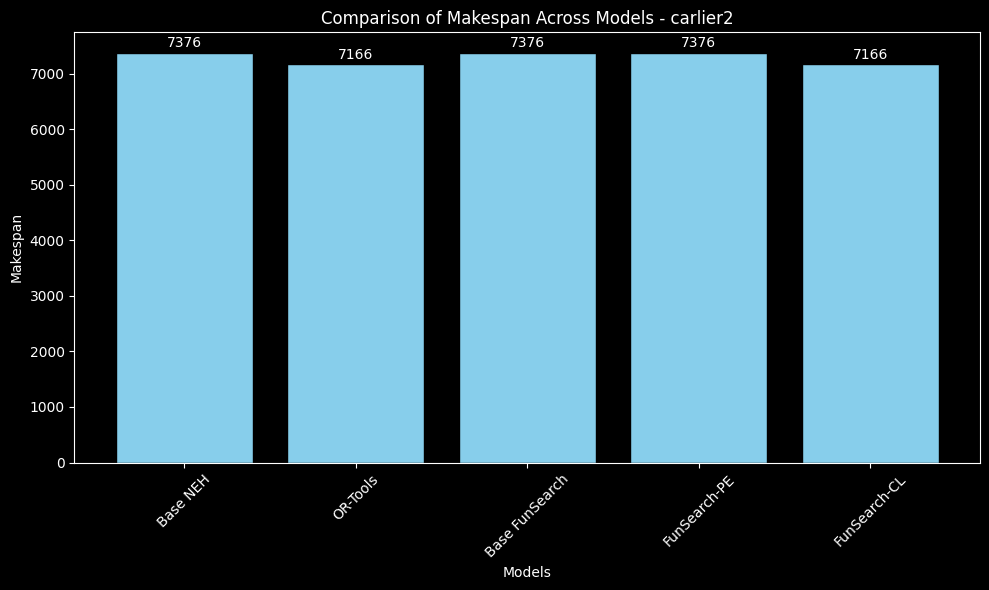

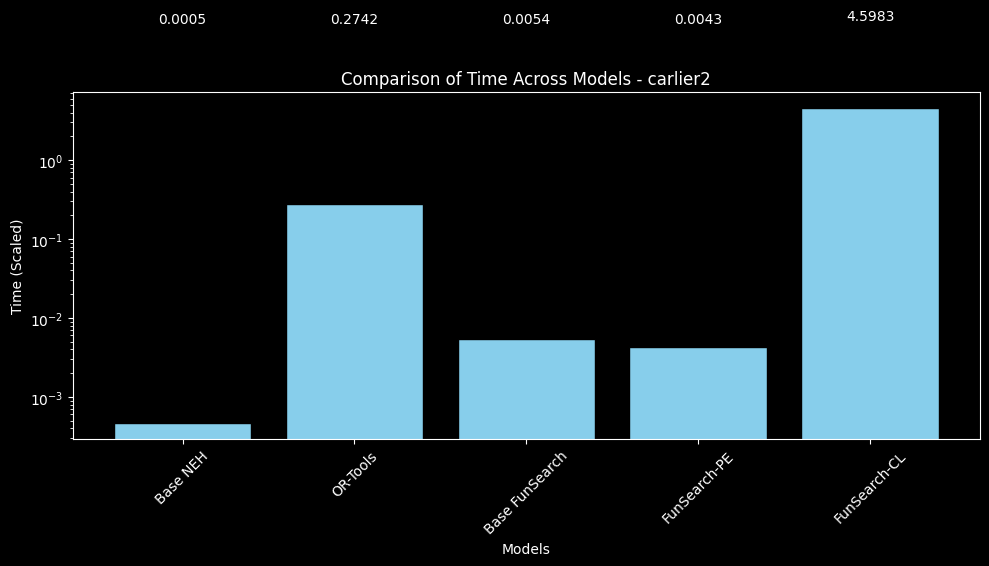

In [ ]:
"""carlier/carlier1"""


eval_instance = 'data/carlier/carlier2.txt'

instance_name = eval_instance.split('/')[-1].split('.')[0]

eval_value = get_metrics(models, eval_instance)
print(f"Makespan: {eval_value['makespan']}")
print(f"Time': {eval_value['time']}")

draw_makespan_comp(eval_value['makespan'], instance_name)

draw_time_comp(eval_value['time'], instance_name)

OR-Tools' execution has reached 90 seconds timelimit!
Makespan: [2391, 0, np.float64(2391.0), np.float64(2370.0), np.float64(2332.0)]
Time: [0.024585962295532227, 90, 2.7696471214294434, 1.5893588066101074, 200.47368502616882]


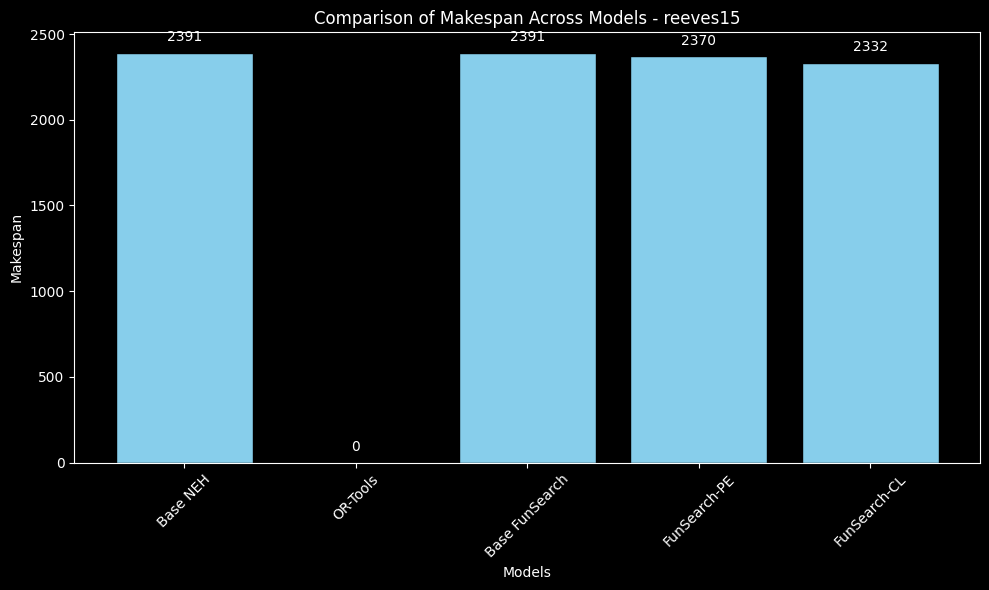

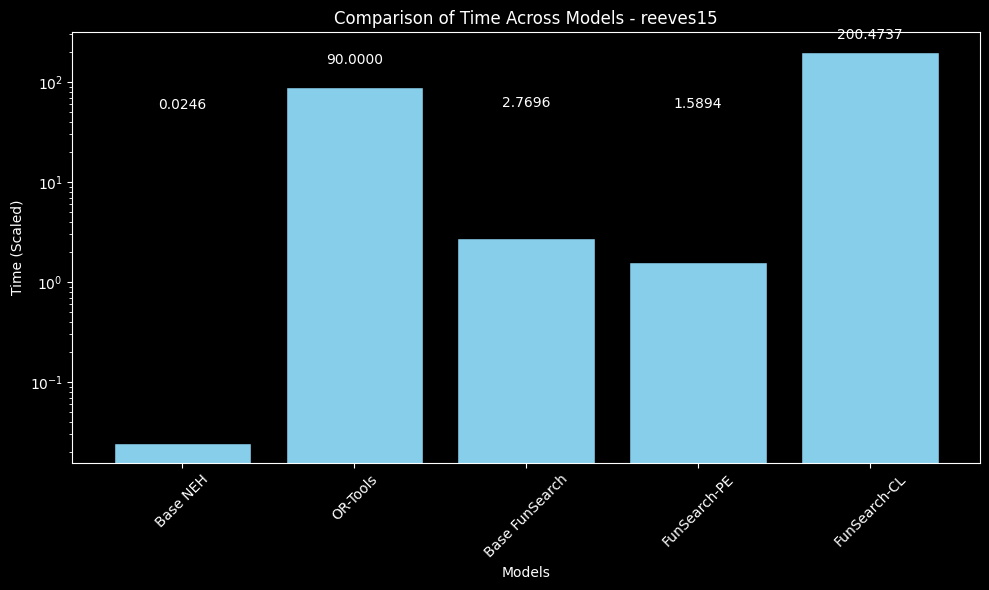

In [57]:
"""reeves/reeves15"""


eval_instance = 'data/reeves/reeves15.txt'

instance_name = eval_instance.split('/')[-1].split('.')[0]

eval_value = get_metrics(models, eval_instance)
print(f"Makespan: {eval_value['makespan']}")
print(f"Time: {eval_value['time']}")

draw_makespan_comp(eval_value['makespan'], instance_name)

draw_time_comp(eval_value['time'], instance_name)